In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# import the LSTM model specified by PyTorch
from LSTM_model import LSTM_regression
from LSTMJOIN_model import LSTM_MultiTask

from sklearn.mixture import GaussianMixture

df1 = pd.read_csv("ogd-smn_gve_h_historical_2000-2009.csv", sep=";")
df2 = pd.read_csv("ogd-smn_gve_h_historical_2010-2019.csv", sep=";")

df = pd.concat([df1, df2], axis=0)

In [ ]:
df.columns

In [90]:
conversion = {
    'tre200h0' : '2m air T hourly mean',
    'tre005h0' : 'air T ground hourly mean',
    'ure200h0' : '2m rel hum hourly mean',
    'pva200h0' : '2m vap pres hourly mean',
    'dkl010h0' : 'wind direction hourly mean',
    'fkl010h0' : 'wind speed (ms) hourly mean',
    'rre150h0' : 'cumulative precipitation',
    'gre000h0' : 'global irradiance',
    'sre000h0' : 'total sunshine'
 }

In [91]:
fets_sel = list(conversion.keys())
fets_sel = ["reference_timestamp"] + fets_sel
fets_sel

['reference_timestamp',
 'tre200h0',
 'tre005h0',
 'ure200h0',
 'pva200h0',
 'dkl010h0',
 'fkl010h0',
 'rre150h0',
 'gre000h0',
 'sre000h0']

In [92]:
# select only the features I want to convert
df = df[fets_sel]

# and then replacce the name
df = df.rename(columns=conversion)

# let's take the referece time as datetime
df["reference_timestamp"] = pd.to_datetime(df["reference_timestamp"], format="%d.%m.%Y %H:%M")

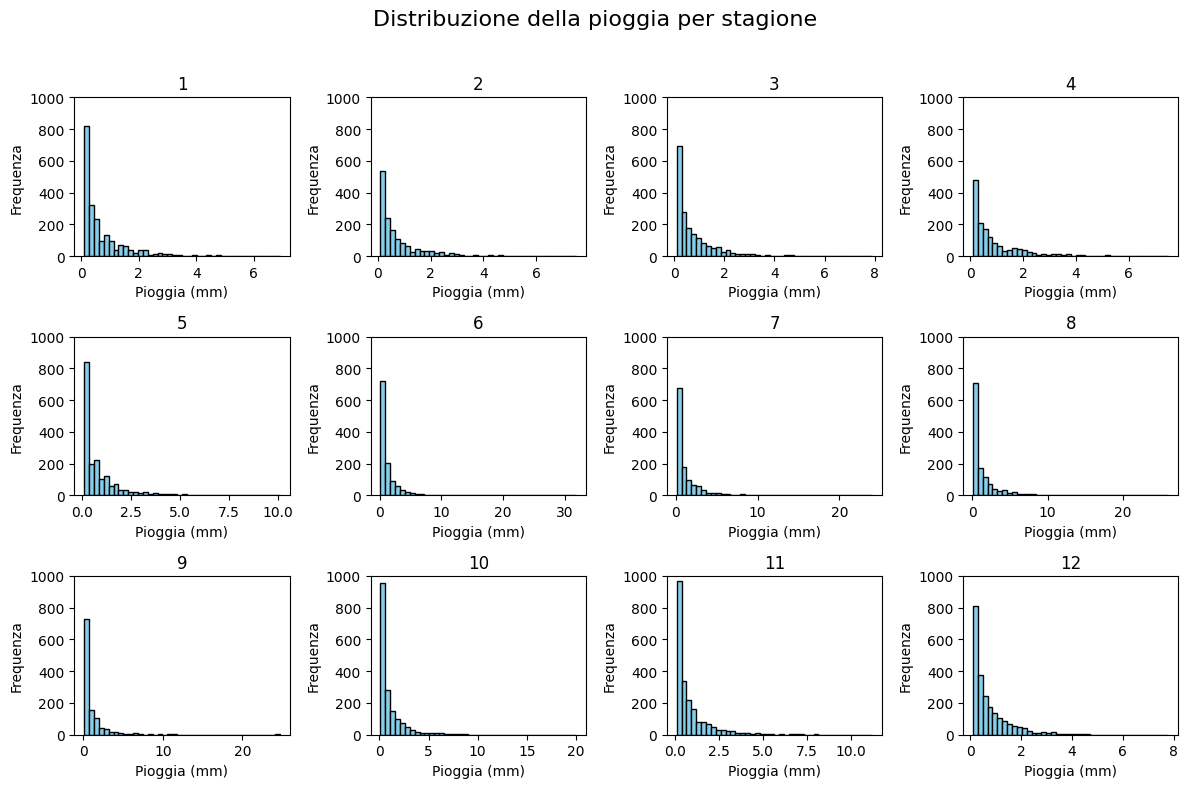

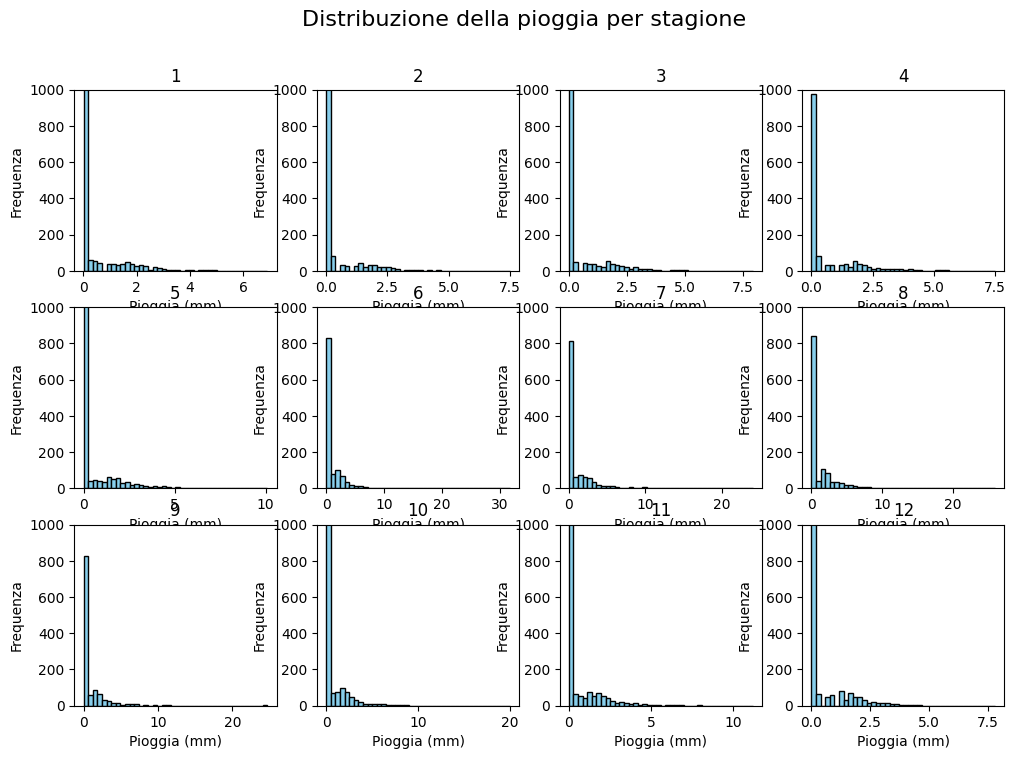

In [94]:
df = df[df['cumulative precipitation'] > 0]

df['month'] = df['reference_timestamp'].dt.month

rain_col = 'cumulative precipitation'

# Crea la figura con 4 subplot
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.suptitle('Distribuzione della pioggia per stagione', fontsize=16)

seasons = ['Inverno', 'Primavera', 'Estate', 'Autunno']
for ax, mon in zip(axes.flatten(), np.arange(1, 13)):
    data = df[df['month'] == mon][rain_col]
    #data = np.log(data)
    ax.hist(data, bins=40, color='skyblue', edgecolor='black')
    ax.set_title(mon)
    ax.set_xlabel('Pioggia (mm)')
    ax.set_ylabel('Frequenza')
    ax.set_ylim(0, 1000)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# gaussian MIXTER MODEL
df = df.dropna()
rain = df['cumulative precipitation'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(rain)
gamma = gmm.predict_proba(rain) 

df['rain_component_1'] = gamma[:, 0] * df['cumulative precipitation']
df['rain_component_2'] = gamma[:, 1] * df['cumulative precipitation']

# VEDIAMO se è meglio il grafico
rain_col = 'rain_component_2'

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.suptitle('Distribuzione della pioggia per stagione', fontsize=16)

seasons = ['Inverno', 'Primavera', 'Estate', 'Autunno']
for ax, mon in zip(axes.flatten(), np.arange(1, 13)):
    data = df[df['month'] == mon][rain_col]
    #data = np.log(data)
    ax.hist(data, bins=40, color='skyblue', edgecolor='black')
    ax.set_title(mon)
    ax.set_xlabel('Pioggia (mm)')
    ax.set_ylabel('Frequenza')
    ax.set_ylim(0, 1000)


Convertiamo il vento

In [75]:
df['wind NS component'] = df['wind speed (ms) hourly mean'] * np.degrees(np.cos(np.radians(df['wind direction hourly mean'])))
df['wind WE component'] = df['wind speed (ms) hourly mean'] * np.degrees(np.sin(np.radians(df['wind direction hourly mean'])))

df = df.drop(columns=['wind speed (ms) hourly mean', 'wind direction hourly mean'])

df

,reference_timestamp,2m air T hourly mean,air T ground hourly mean,2m rel hum hourly mean,2m vap pres hourly mean,cumulative precipitation,global irradiance,total sunshine,wind NS component,wind WE component
0,2000-01-01 00:00:00,0.8,-0.3,85.7,5.5,0.0,2.0,0.0,4.051423e+00,-4.051423
1,2000-01-01 01:00:00,0.8,-0.2,84.2,5.5,0.0,2.0,0.0,0.000000e+00,0.000000
2,2000-01-01 02:00:00,0.8,-0.2,83.8,5.4,0.0,2.0,0.0,0.000000e+00,0.000000
3,2000-01-01 03:00:00,0.6,-0.5,86.1,5.5,0.0,0.0,0.0,0.000000e+00,0.000000
4,2000-01-01 04:00:00,0.3,-2.0,86.8,5.4,0.0,-3.0,0.0,-1.052506e-15,-5.729578
...,...,...,...,...,...,...,...,...,...,...
87643,2019-12-31 19:00:00,2.0,1.8,92.2,6.5,0.0,1.0,0.0,2.341057e+01,-45.945822
87644,2019-12-31 20:00:00,1.9,1.8,93.0,6.5,0.0,1.0,0.0,-9.472558e-15,-51.566202
87645,2019-12-31 21:00:00,2.0,1.8,93.4,6.6,0.0,1.0,0.0,1.820822e+01,-35.735639
87646,2019-12-31 22:00:00,2.2,2.0,93.6,6.7,0.0,1.0,0.0,4.539054e+01,-6.379225


In [76]:
# remove the nan so far
df = df.dropna()

df

,reference_timestamp,2m air T hourly mean,air T ground hourly mean,2m rel hum hourly mean,2m vap pres hourly mean,cumulative precipitation,global irradiance,total sunshine,wind NS component,wind WE component
0,2000-01-01 00:00:00,0.8,-0.3,85.7,5.5,0.0,2.0,0.0,4.051423e+00,-4.051423
1,2000-01-01 01:00:00,0.8,-0.2,84.2,5.5,0.0,2.0,0.0,0.000000e+00,0.000000
2,2000-01-01 02:00:00,0.8,-0.2,83.8,5.4,0.0,2.0,0.0,0.000000e+00,0.000000
3,2000-01-01 03:00:00,0.6,-0.5,86.1,5.5,0.0,0.0,0.0,0.000000e+00,0.000000
4,2000-01-01 04:00:00,0.3,-2.0,86.8,5.4,0.0,-3.0,0.0,-1.052506e-15,-5.729578
...,...,...,...,...,...,...,...,...,...,...
87643,2019-12-31 19:00:00,2.0,1.8,92.2,6.5,0.0,1.0,0.0,2.341057e+01,-45.945822
87644,2019-12-31 20:00:00,1.9,1.8,93.0,6.5,0.0,1.0,0.0,-9.472558e-15,-51.566202
87645,2019-12-31 21:00:00,2.0,1.8,93.4,6.6,0.0,1.0,0.0,1.820822e+01,-35.735639
87646,2019-12-31 22:00:00,2.2,2.0,93.6,6.7,0.0,1.0,0.0,4.539054e+01,-6.379225


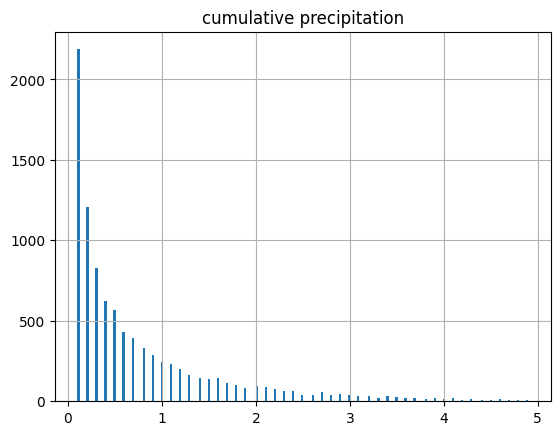

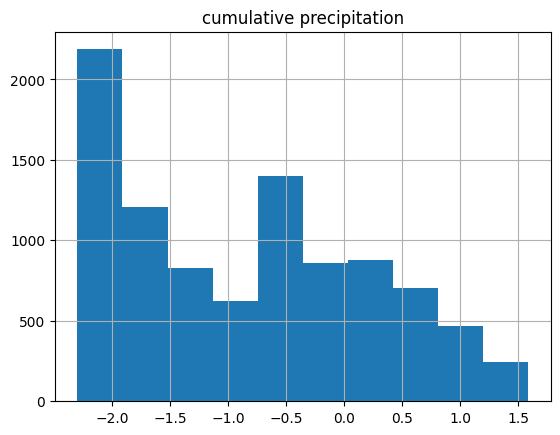

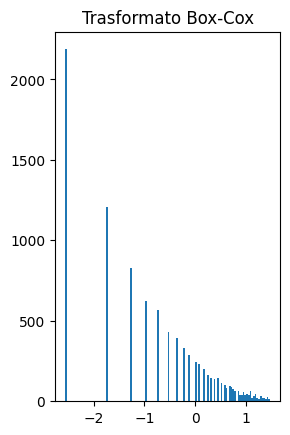

In [34]:
df = df[(df['cumulative precipitation'] > 0) & (df['cumulative precipitation'] < 5)]

# df['cumulative precipitation'] = np.log(df['cumulative precipitation'])
y_transformed, lambda_opt = stats.boxcox(df['cumulative precipitation'])
df.hist('cumulative precipitation', bins=200)
plt.show()

a = pd.DataFrame(np.log(df['cumulative precipitation']))

a.hist('cumulative precipitation')
plt.show()

y_transformed, lambda_opt

plt.subplot(1,2,2)
plt.hist(y_transformed, bins=120)
plt.title("Trasformato Box-Cox")

plt.show()

In [ ]:
# costruiamo i peso
neg = df[df['cumulative precipitation'] == 0].shape[0]
pos = df[df['cumulative precipitation'] != 0].shape[0]
weight = neg / pos
print(weight)

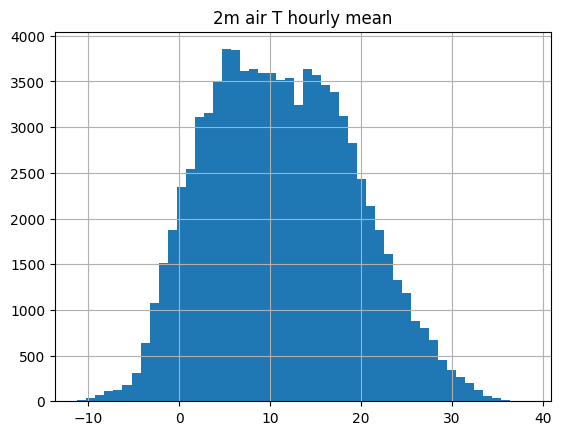

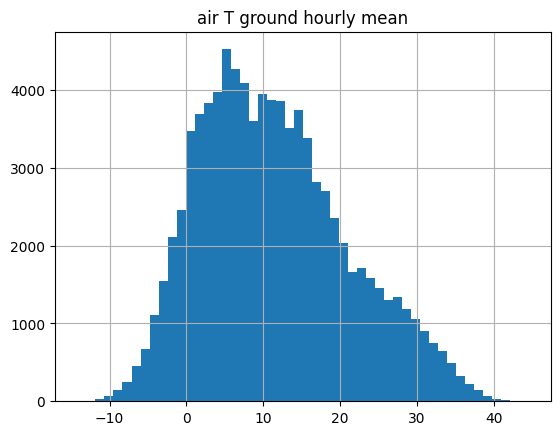

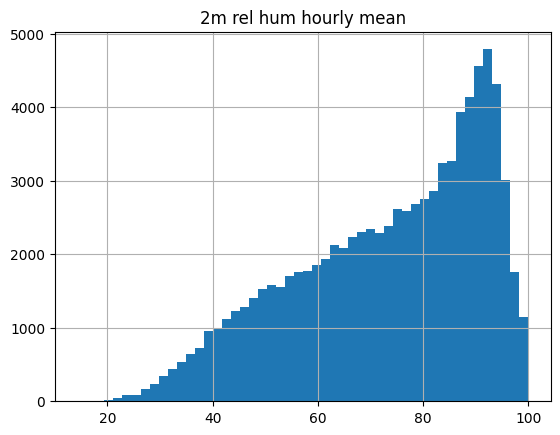

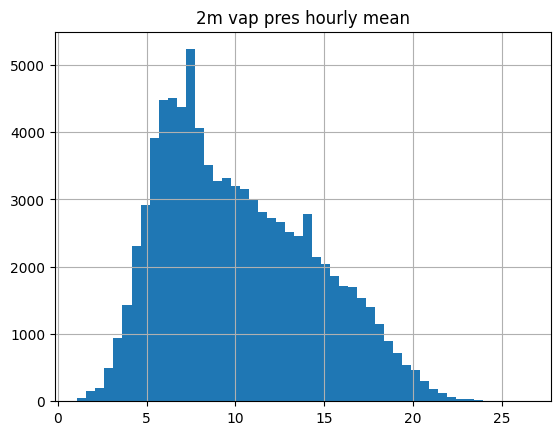

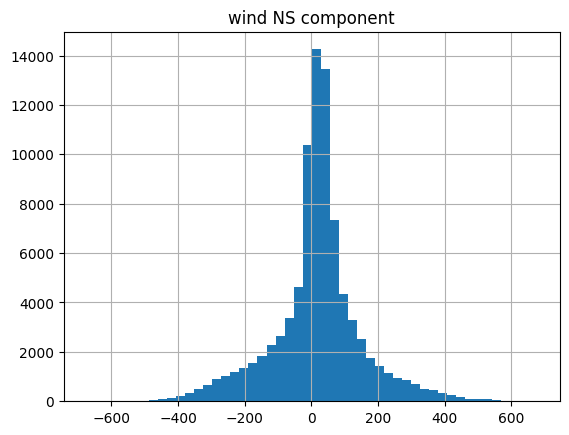

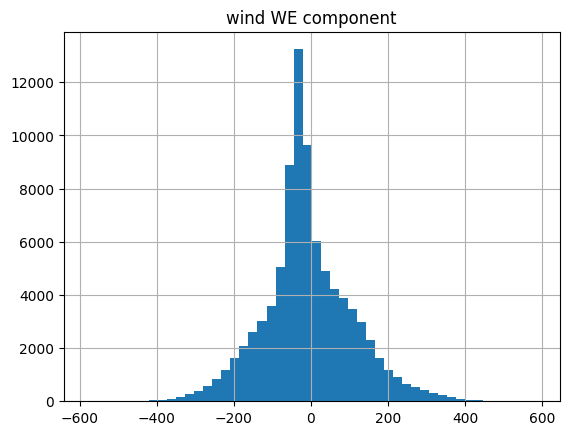

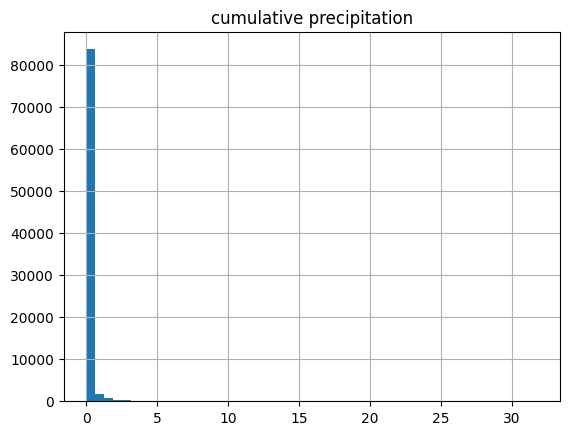

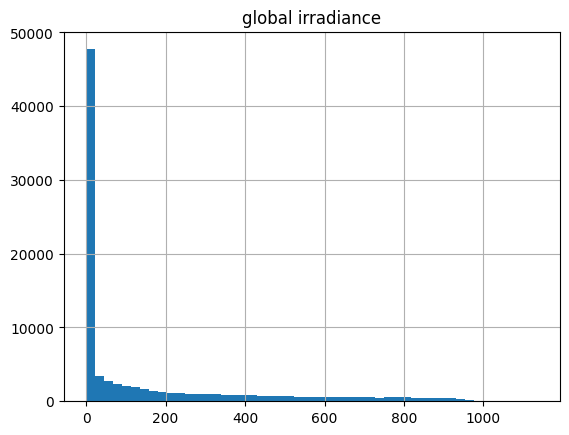

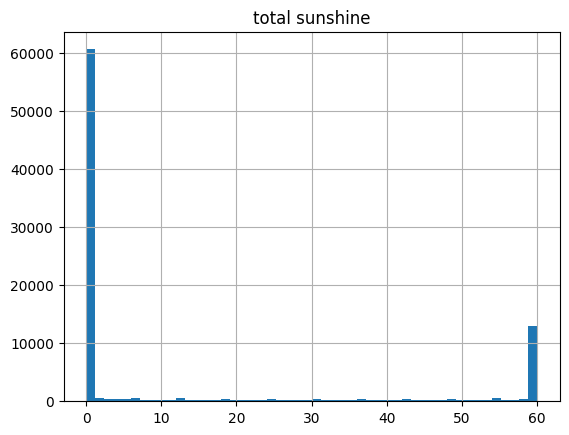

In [7]:
cols = ['2m air T hourly mean',
        'air T ground hourly mean',
        '2m rel hum hourly mean',
        '2m vap pres hourly mean',
        'wind NS component',
        'wind WE component',
        'cumulative precipitation',
        'global irradiance',
        'total sunshine'
]
for col in cols:
    df.hist(col, bins=50)
    plt.show()

Trasformazione logaritmica

In [ ]:
# cols = ['2m rel hum hourly mean',
#         '2m vap pres hourly mean',
#         'cumulative precipitation',
#         'global irradiance',
#         'total sunshine'
# ]

# for col in cols:
#     mask = df[col] != 0
#     df.loc[mask, col] = np.log(df.loc[mask, col])
#     df.loc[~mask, col] = 0

C:\Users\marro\AppData\Local\Temp\ipykernel_27664\239247445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative precipitation'] = np.log1p(df['cumulative precipitation'])


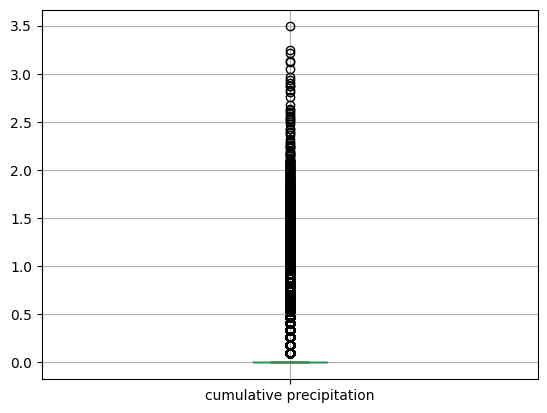

In [8]:
df['cumulative precipitation'] = np.log1p(df['cumulative precipitation'])
# df.loc[mask, 'cumulative precipitation'] = np.log(df.loc[mask, 'cumulative precipitation'])
# df.loc[~mask, 'cumulative precipitation'] = 0
df.boxplot('cumulative precipitation')
plt.show()

In [9]:
df = df.drop(columns=['2m air T hourly mean', 'total sunshine'])

# LSTM MODEL APPLICATION

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(121)

print(f"Cuda avaibility: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

seq_len = 8

# selezione feature e target
features = df.drop(columns=['cumulative precipitation', 'reference_timestamp']).values
targets = df["cumulative precipitation"].values.reshape(-1,1)

# scaler
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

features_scaled = feature_scaler.fit_transform(features)
targets_scaled = target_scaler.fit_transform(targets)

# target binario non scalato
targets_bin = (targets > 0.1)

# creazione sequenze
X = np.array([features_scaled[i:i+seq_len] for i in range(len(features_scaled)-seq_len)], dtype=np.float32)
y = np.array([targets_scaled[i+seq_len-1] for i in range(len(targets_scaled)-seq_len)], dtype=np.float32).reshape(-1,1)

y_bin = np.array([targets_bin[i+seq_len-1] for i in range(len(targets_bin)-seq_len)], dtype=np.float32).reshape(-1,1)

# Dividiamo prima in train+val e test (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# conversione in tensori PyTorch
X_train_torch = torch.from_numpy(X_train).to(device)
y_train_torch = torch.from_numpy(y_train).to(device)

X_test_torch = torch.from_numpy(X_test).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

# divisione per la classificazione ----------------------------------
_, _, y_train_val_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42
)

_, _, y_train_bin, y_val_bin = train_test_split(
    X_train_val, y_train_val_bin, test_size=0.25, random_state=42
)

# conversione in tensori PyTorch CLASSIFICAZIONE

y_train_bin_torch = torch.from_numpy(y_train_bin).to(device)
y_test_bin_torch = torch.from_numpy(y_test_bin).to(device)

# BCE vuole float...
y_train_bin_torch = y_train_bin_torch.float()
y_test_bin_torch  = y_test_bin_torch.float()
# --------------------------------------------------------------------

Cuda avaibility: True
Device: cuda


Regressione LSTM per pioggia

In [ ]:
model = LSTM(in_feat=8, hidden_size=16, out_feat=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.6)

epochs = 000 # circa 40 minuti

loss_tot = []
val_loss_tot = []

train_mae_tot = []
train_rmse_tot = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_torch)
    loss = criterion(out, y_train_torch)
    loss.backward()

    scheduler.step()
    optimizer.step()

    loss_tot.append(loss.item())

    model.eval()
    with torch.no_grad():
        mse_train = torch.mean((out - y_train_torch) ** 2).item()
        rmse_train = mse_train ** 0.5
        mae_train = torch.mean(torch.abs(out - y_train_torch)).item()
        train_mae_tot.append(mae_train)
        train_rmse_tot.append(rmse_train)


        val_out = model(X_test_torch)
        val_loss = criterion(val_out, y_test_torch).item()
        val_loss_tot.append(val_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, MAE: {mae_train:.4f} RMSE : {rmse_train:.4f}")

In [ ]:
plt.plot(np.arange(len(loss_tot)), loss_tot, label='train')
plt.plot(np.arange(len(val_loss_tot)), val_loss_tot, label='test')
plt.legend()
plt.show()

LSTM per classificazione (anche se andrebbe fatta prima)

In [14]:
model = LSTM(in_feat=6, hidden_size=16, out_feat=1).to(device)

weight *= 0.5 # best so far 0.3
pos_weight = torch.tensor([weight], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)

epochs = 2000

loss_tot = []
val_loss_tot = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_torch)
    loss = criterion(out, y_train_bin_torch)
    loss.backward()

    #scheduler.step()
    optimizer.step()

    loss_tot.append(loss.item())

    model.eval()
    with torch.no_grad():

        val_out = model(X_test_torch)
        val_loss = criterion(val_out, y_test_bin_torch).item()
        val_loss_tot.append(val_loss)

        train_preds = torch.sigmoid(out).squeeze()
        train_acc = ((train_preds > 0.5).float() == y_train_bin_torch.squeeze()).float().mean().item()
        
        val_preds = torch.sigmoid(val_out).squeeze()
        val_acc = ((val_preds > 0.5).float() == y_test_bin_torch.squeeze()).float().mean().item()

        probs = torch.sigmoid(val_out).squeeze()         # (N,)
        preds_label = (probs > 0.5).int()
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 0, Loss: 0.6842, Train Acc: 0.9155, Val Acc: 0.9158
Epoch 100, Loss: 0.6640, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 200, Loss: 0.6424, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 300, Loss: 0.6158, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 400, Loss: 0.5807, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 500, Loss: 0.5358, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 600, Loss: 0.4852, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 700, Loss: 0.4420, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 800, Loss: 0.4169, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 900, Loss: 0.4036, Train Acc: 0.9159, Val Acc: 0.9162
Epoch 1000, Loss: 0.3957, Train Acc: 0.9161, Val Acc: 0.9166
Epoch 1100, Loss: 0.3904, Train Acc: 0.9175, Val Acc: 0.9178
Epoch 1200, Loss: 0.3862, Train Acc: 0.9184, Val Acc: 0.9192
Epoch 1300, Loss: 0.3826, Train Acc: 0.9192, Val Acc: 0.9199
Epoch 1400, Loss: 0.3791, Train Acc: 0.9197, Val Acc: 0.9203
Epoch 1500, Loss: 0.3757, Train Acc: 0.9199, Val Acc: 0.9205
Epoch 1600, Loss: 0.3723, Train Acc:

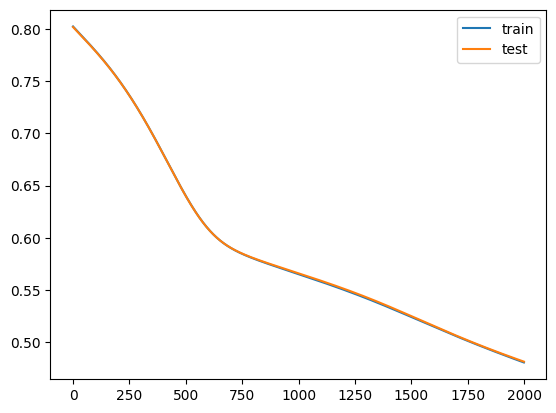

In [12]:
plt.plot(np.arange(len(loss_tot)), loss_tot, label='train')
plt.plot(np.arange(len(val_loss_tot)), val_loss_tot, label='test')
plt.legend()
plt.show()

In [13]:
# --- Calcolo metriche ---
preds_np  = preds_label.cpu().numpy()
probs_np  = probs.cpu().numpy()

precision = precision_score(y_test_bin, preds_np)
recall    = recall_score(y_test_bin, preds_np)
f1        = f1_score(y_test_bin, preds_np)
roc_auc   = roc_auc_score(y_test_bin, preds_np)
cm        = confusion_matrix(y_test_bin, preds_np)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

Precision: 0.3926
Recall:    0.5017
F1-score:  0.4405
ROC-AUC:   0.7154
Confusion Matrix:
[[14882  1137]
 [  730   735]]


Modello multitask

In [ ]:
model = LSTM_MultiTask(in_feat=6, hidden_size=16).to(device)

# pesi per classi sbilanciati
n_pos = y_train_bin_torch.sum()
n_neg = y_train_bin_torch.numel() - n_pos
pos_weight = torch.tensor([n_neg / n_pos], device=device)

criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion_reg = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

a, b = 1, 0.8

epochs = 20000 # circa 40 minuti

loss_tot = []
val_loss_tot = []

loss_reg_train = []
loss_cls_train = []

loss_reg_test = []
loss_cls_test = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out_reg, out_cls = model(X_train_torch)
    loss_reg = criterion_reg(out_reg, y_train_torch)
    loss_cls = criterion_cls(out_cls, y_train_bin_torch)

    loss = a * loss_reg + b * loss_cls

    loss.backward()

    optimizer.step()
    scheduler.step()

    loss_tot.append(loss.item())

    loss_reg_train.append(loss_reg.item())
    loss_cls_train.append(loss_cls.item())

    model.eval()
    with torch.no_grad():

        val_out_reg, val_out_cls = model(X_test_torch)
        val_loss_reg = criterion_reg(val_out_reg, y_test_torch)
        val_loss_cls = criterion_cls(val_out_cls, y_test_bin_torch)
        val_loss = a * val_loss_reg + b * val_loss_cls
        val_loss_tot.append(val_loss.item())

        train_preds = torch.sigmoid(out_cls).squeeze()
        train_acc = ((train_preds > 0.5).float() == y_train_bin_torch.squeeze()).float().mean().item()
        
        val_preds = torch.sigmoid(val_out_cls).squeeze()
        val_acc = ((val_preds > 0.5).float() == y_test_bin_torch.squeeze()).float().mean().item()

        probs = torch.sigmoid(val_out_cls).squeeze()
        preds_label = (probs > 0.5).int()

        mse_train = torch.mean((out_reg - y_train_torch) ** 2).item()
        rmse_train = mse_train ** 0.5
        mae_train = torch.mean(torch.abs(out_reg - y_train_torch)).item()

        loss_reg_test.append(val_loss_reg.item())
        loss_cls_test.append(val_loss_cls.item())
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, MAE: {mae_train}")

In [ ]:
plt.plot(np.arange(len(loss_tot)), loss_tot, label='loss tot train')
plt.plot(np.arange(len(val_loss_tot)), val_loss_tot, label='loss tot test')
plt.legend()
plt.show()
plt.plot(np.arange(len(loss_reg_train)), loss_reg_train, label='loss reg train')
plt.plot(np.arange(len(loss_reg_test)), loss_reg_test, label='loss reg test')
plt.legend()
plt.show()
plt.plot(np.arange(len(loss_cls_train)), loss_cls_train, label='loss cls train')
plt.plot(np.arange(len(loss_cls_test)), loss_cls_test, label='loss cls test')
plt.legend()
plt.show()

In [ ]:
# --- Calcolo metriche ---
preds_np  = preds_label.cpu().numpy()
probs_np  = probs.cpu().numpy()

precision = precision_score(y_test_bin, preds_np)
recall    = recall_score(y_test_bin, preds_np)
f1        = f1_score(y_test_bin, preds_np)
roc_auc   = roc_auc_score(y_test_bin, preds_np)
cm        = confusion_matrix(y_test_bin, preds_np)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

In [ ]:
model.eval()
val_out_reg, val_out_cls = model(X_test_torch)

val_out_cls = torch.sigmoid(val_out_cls)
val_out_cls = (val_out_cls > 0.5).float().cpu().numpy()
#val_out_cls = val_out_cls.detach().cpu().numpy()

val_out_reg = val_out_reg.detach().cpu().numpy()

precip_pred = val_out_cls
print(val_out_cls)

In [ ]:
precip_pred = precip_pred[:500]
y_test = y_test[:500]
plt.plot(np.arange(precip_pred.shape[0]), precip_pred, label='prediction')
plt.plot(np.arange(y_test.shape[0]), y_test, label='True')
plt.legend()
plt.show()